In [1]:
cd ..

/home/aga/fixated_eye_model


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

from src.gauss import EMGauss
from utils.image_gen import ImageGenerator
from sparse_coder.prep_field_dataset import get_data_matrix

In [3]:
l_i = 20
ds = 0.3
de = 1.09
n_t = 150

In [4]:
l_n = (l_i * ds / np.sqrt(2))

In [5]:
mat = get_data_matrix(path='sparse_coder/data/final/IMAGES.npy', l_patch=l_i, n_patches=10)

In [6]:
emg = EMGauss(
    l_i=l_i, 
    motion_gen={'mode': 'Diffusion', 'dc': 4.},
    motion_prior={'dc': 10.},
    n_t=n_t,
    ds=ds,
    de=de,
    n_p=50,
    print_mode=True,
    l_n=l_n,
    sig_obs=0.1
)

<matplotlib.colorbar.Colorbar instance at 0x7f3ab03544d0>

/home/aga/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


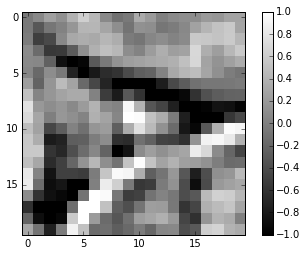

In [7]:
s_gen = mat[3].astype('float32')
s_gen = np.clip(s_gen, -1, 1)
plt.imshow(s_gen.reshape(l_i, l_i))
plt.colorbar()

In [8]:
m, xr, yr = emg.gen_data(s_gen)

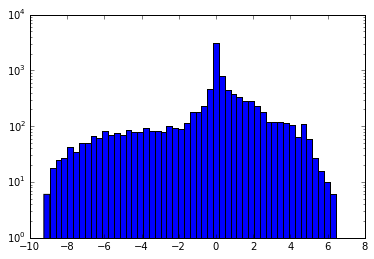

In [9]:
plt.hist(m.ravel(), bins=50);
plt.yscale('log')

In [10]:
def snr(s, s_est):
    return (s ** 2).sum() / ((s - s_est) ** 2).sum()

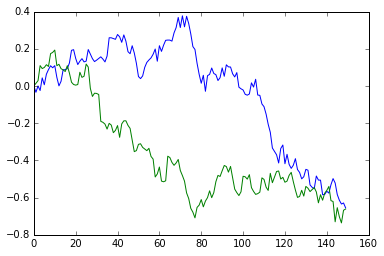

In [11]:
plt.plot(xr)
plt.plot(yr)

In [12]:
s, data = emg.run_em(m, n_passes=1, n_itr=n_t, reg=1.)

In [13]:
snr_list = [snr(s_gen, np.clip(est, -1, 1)) for est in data]

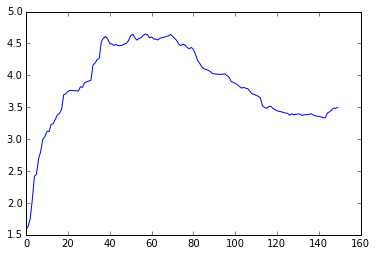

In [14]:
plt.plot(snr_list)

In [15]:
with emg.tb.sess.as_default():
    xe, ye = emg.tb.sess.run([emg.tb.t_xe, emg.tb.t_ye])

In [16]:
from src.gauss_plots import plot_image, plot_rfs, compare_fourier

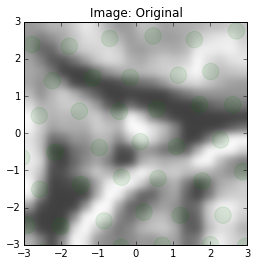

In [17]:
ax = plt.axes()
plot_rfs(ax, xe, ye, de)

plot_image(s_gen.reshape(l_i, l_i), ds=ds, title='Image: {}'.format('Original'), alpha=0.75)

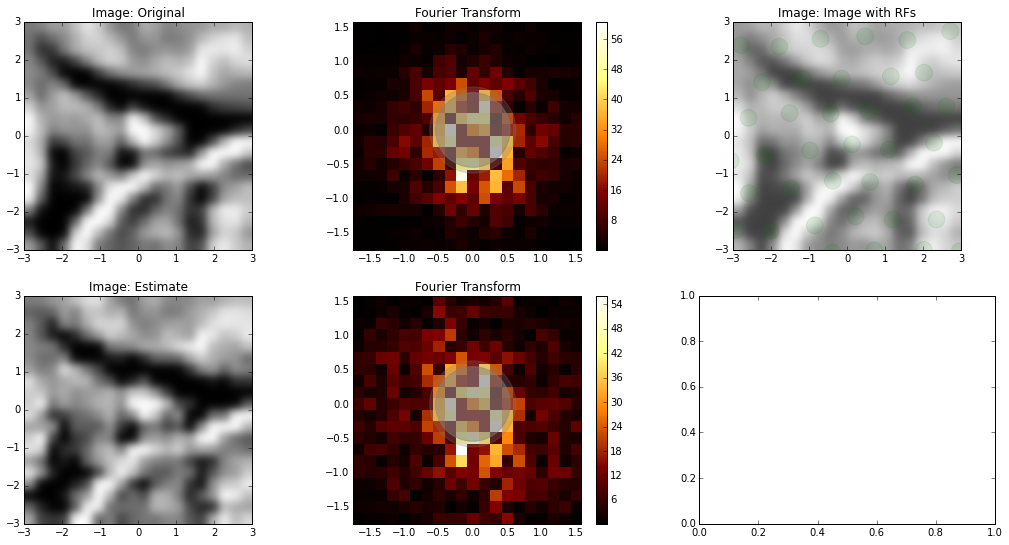

In [18]:
compare_fourier(s_gen.reshape(l_i, l_i), data[-1].reshape(l_i, l_i), l_i, ds, de, xe, ye)

In [ ]:
plt.hist(s_gen - data[-1])
plt.imshow((s_gen - data[-1]).reshape(l_i, l_i))
plt.colorbar()